In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%load_ext cudf.pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import warnings  # To suppress noisy warnings while keeping the code beginner-friendly
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Nice statistical plots

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split  # Robust CV on imbalanced/shifted targets
from sklearn.metrics import roc_auc_score, log_loss  # Key metrics for probabilistic classifiers
from sklearn.preprocessing import StandardScaler  # Scaling numeric features

# We’ll use LightGBM for strong tabular performance and robustness.
# If not installed: pip install lightgbm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e12/sample_submission.csv
/kaggle/input/playground-series-s5e12/train.csv
/kaggle/input/playground-series-s5e12/test.csv
/kaggle/input/diabetes-health-indicators-dataset/diabetes_dataset.csv


# Load the data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e12/test.csv')
org = pd.read_csv('/kaggle/input/diabetes-health-indicators-dataset/diabetes_dataset.csv')

In [3]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [4]:
target = 'diagnosed_diabetes'
cat_cols = test.select_dtypes(exclude='number').columns.to_list()
base = [col for col in train.columns if col not in [target]]
num_cols = [col for col in base if col not in cat_cols]

In [5]:
orig = []
global_mean = train[target].mean()

for col in base:
    mean_map = org.groupby(col)[target].mean()
    new_col = f'org_mean_{col}'
    train[f"org_mean_{col}"] = train[col].map(mean_map).fillna(global_mean)
    test[f"org_mean_{col}"] = test[col].map(mean_map).fillna(global_mean)
    orig.append(new_col)

In [6]:
for col in cat_cols:
    train[col] = train[col].map(train[col].value_counts())
    test[col] = test[col].map(train[col].value_counts()) 

# Feature engineering
Created two new non-linear features based on the EDA notebook.

In [7]:
def fe(df):
    df['log_physical'] = np.log1p(df['physical_activity_minutes_per_week'])
    df['sqrt_triglycerides'] = np.sqrt(df['triglycerides'])

    return df

train = fe(train)
test = fe(test)
inter = ['log_physical', 'sqrt_triglycerides']

In [8]:
features = base + orig + inter

In [9]:
X = train[features]
y = train[target]

In [10]:
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

In [11]:
params = {
    'n_estimators': 4123, 
    'learning_rate': 0.012583005624154356, 
    'max_depth': 3, 
    'alpha': 0.006122955361272888, 
    'lambda': 4.979756782201132, 
    'subsample': 0.8246846548997797, 
    'colsample_bytree': 0.5073072612487087, 
    'min_child_weight': 2,
    'device': 'cuda',
    'objective': 'binary:logistic',
    'n_jobs': -1,
    'random_state': 42,
    "grow_policy": "lossguide",
    'scale_pos_weight': 0.78,
    'early_stopping_rounds': 200,
}

In [12]:
oof_xgb = np.zeros(len(X))
test_xgb = np.zeros(len(test))

In [13]:
for fold, (train_index, valid_index) in enumerate(skf.split(X, y), 1):
    print(f"\n🚀 Training Fold {fold} on GPU...")
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    X_test = test[features].copy()

    xgb = XGBClassifier(**params).fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    preds = xgb.predict_proba(X_valid)[:, 1]
    oof_xgb[valid_index] = preds

    auc_score = roc_auc_score(y_valid, preds)
    print(f'Fold{fold} AUC:{auc_score:.4f}')
    test_xgb += xgb.predict_proba(X_test)[:, 1]

test_xgb /= n_folds
overall_auc = roc_auc_score(y, oof_xgb)
print(30*'=')
print(f'✅Overall OOF AUC: {overall_auc:.4f}')
print(30*'=')


🚀 Training Fold 1 on GPU...
Fold1 AUC:0.7297

🚀 Training Fold 2 on GPU...
Fold2 AUC:0.7300

🚀 Training Fold 3 on GPU...
Fold3 AUC:0.7290

🚀 Training Fold 4 on GPU...
Fold4 AUC:0.7280

🚀 Training Fold 5 on GPU...
Fold5 AUC:0.7298

🚀 Training Fold 6 on GPU...
Fold6 AUC:0.7290

🚀 Training Fold 7 on GPU...
Fold7 AUC:0.7276

🚀 Training Fold 8 on GPU...
Fold8 AUC:0.7318

🚀 Training Fold 9 on GPU...
Fold9 AUC:0.7311

🚀 Training Fold 10 on GPU...
Fold10 AUC:0.7288
✅Overall OOF AUC: 0.7295


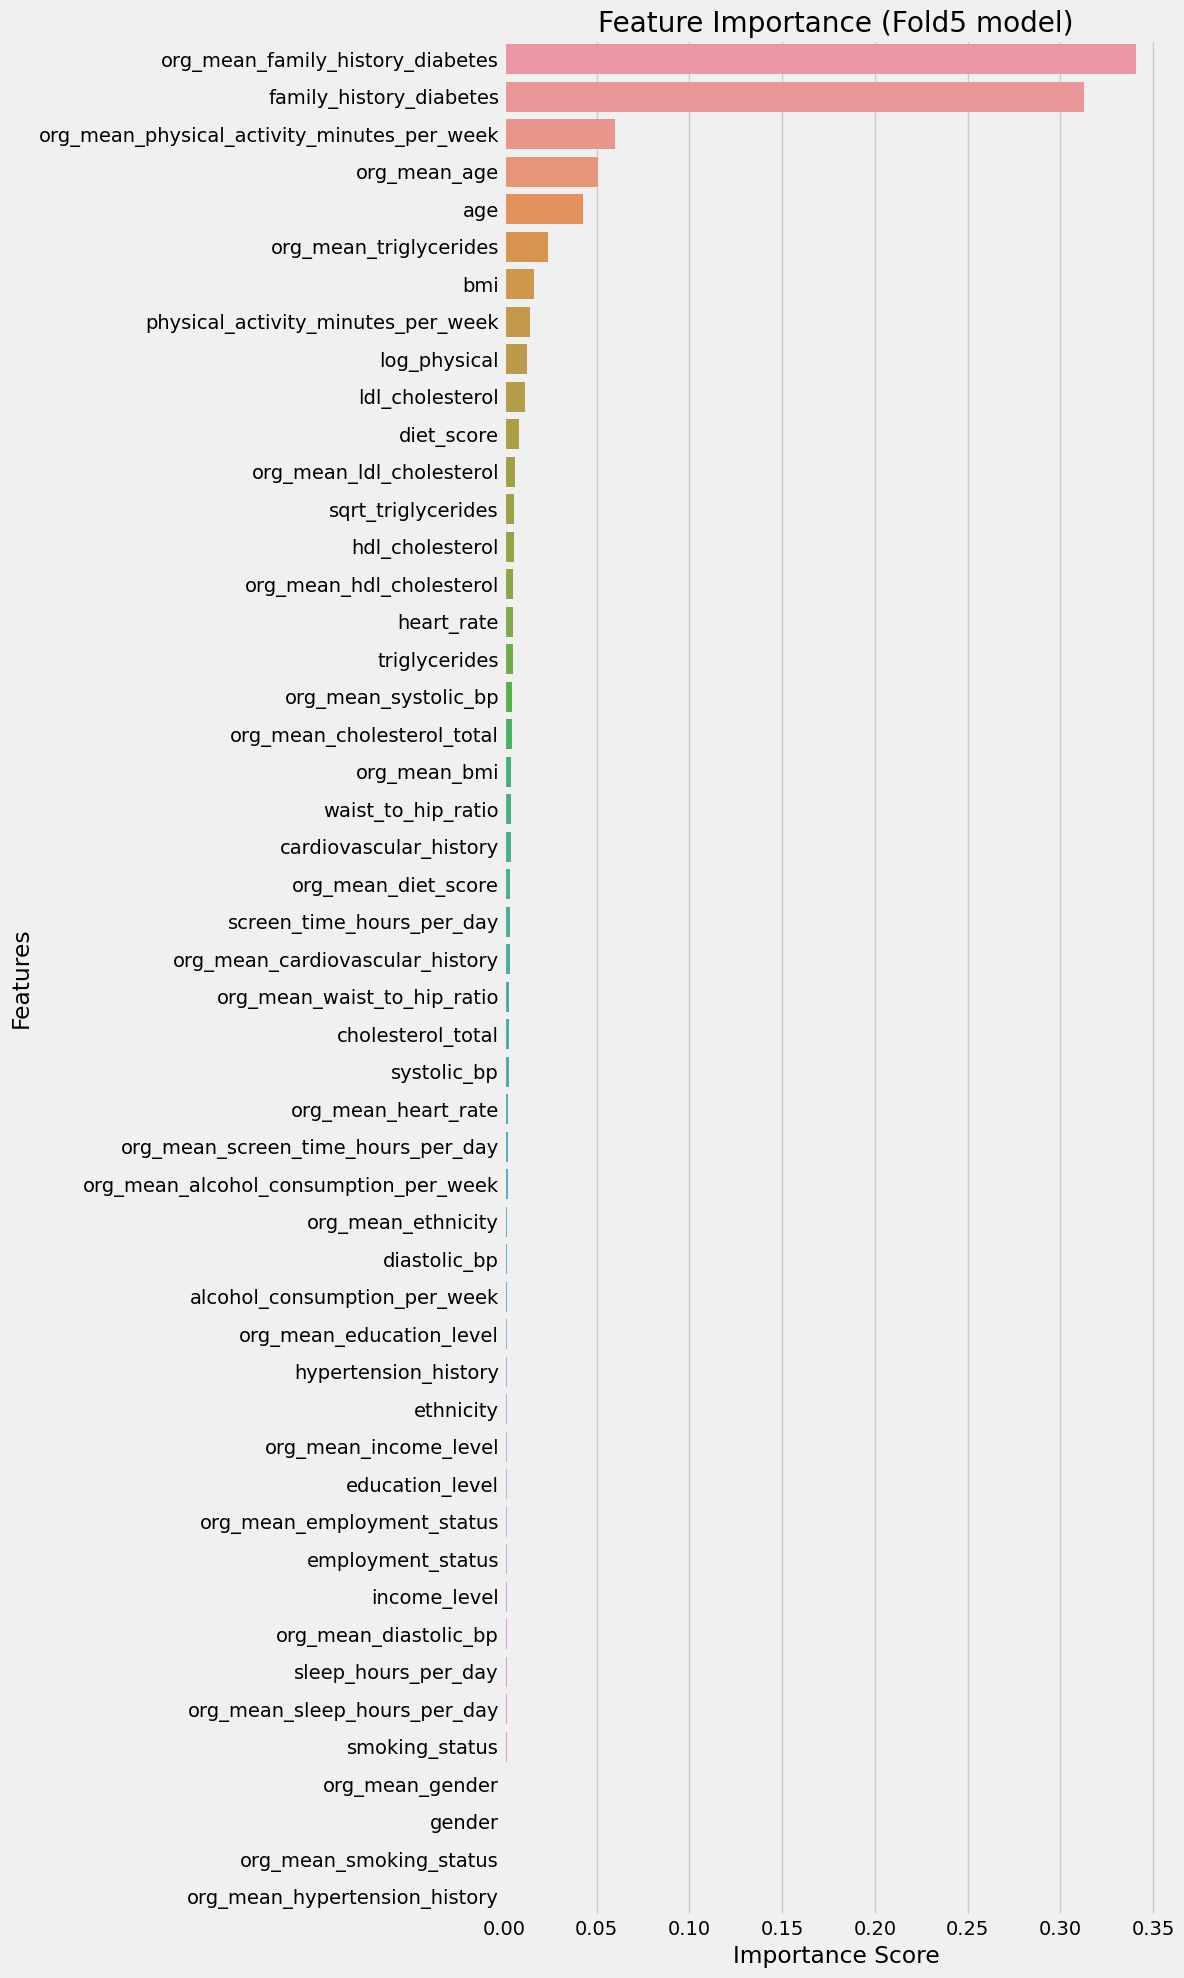

In [14]:
importances = xgb.feature_importances_

df = pd.DataFrame({
    'feature': X_train.columns,
    'importances': importances
})

df = df.sort_values('importances', ascending=False)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 20))
sns.barplot(x='importances', 
            y='feature', 
            data=df) 
plt.title('Feature Importance (Fold5 model)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [15]:
sub = pd.read_csv('/kaggle/input/playground-series-s5e12/sample_submission.csv')
sub['diagnosed_diabetes'] = test_xgb
sub.to_csv('submission.csv', index=False)
sub.head()

,id,diagnosed_diabetes
0,700000,0.414714
1,700001,0.631988
2,700002,0.726282
3,700003,0.306640
4,700004,0.900937
